# 05 - Defending against Adversarial Examples

We saw how to attack models, but we also need to take into account defending against them.
In particular, we will learn here how to create a simplified version of **adversarial training**.

As seen in class, this technique is defined as:
$$
\min_{\boldsymbol{\theta}} \sum_{(\boldsymbol{x},y) \in D} \max_{\boldsymbol{\delta}} L(\boldsymbol{x}+\boldsymbol{\delta}, y;\boldsymbol{\theta})
$$

which accounts for computing the best parameters $\boldsymbol{\theta}$ that minimizes the error in the presence of worst-case adversarial noise $\boldsymbol{\delta}$.

This is nice in theory, but implementing this is hard and resource demanding.

In [1]:
try:
    import secmlt
except ImportError:
    print("Installing the dependancies")
    %pip install git+https://github.com/pralab/secml-torch


In [2]:
import torch
import numpy as np
import random

seed = 999
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from secmlt.models.pytorch.base_pytorch_trainer import BasePyTorchTrainer
from secmlt.metrics.classification import Accuracy
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import torch


def plot_decision_regions(model, X, y, title="Decision Regions"):
    """
    Plot decision regions for a PyTorch model.

    Args:
        model: PyTorch model (must be in eval mode)
        X: Input features as tensor
        y: Labels as tensor
        title: Plot title
    """
    # Convert tensors to numpy for plotting
    X_np = X.detach().numpy()
    y_np = y.detach().numpy()

    # Create a mesh grid
    x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))

    # Get predictions for each point in the mesh
    X_mesh = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        model.eval()
        Z = model(X_mesh)
        Z = torch.argmax(Z, dim=1)
    Z = Z.numpy().reshape(xx.shape)

    # Plot decision regions
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')

    # Plot data points
    scatter = plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np,
                         cmap='viridis')

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.show()


centers = [(0, 1), (0, 0), (1, 1)]
cluster_std = 0.25
X_train, y_train = make_blobs(n_samples=500,
                  centers=centers,
                  n_features=2,
                  cluster_std=cluster_std,
                  random_state=seed)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test, y_test = make_blobs(n_samples=100,
                  centers=centers,
                  n_features=2,
                  cluster_std=cluster_std,
                  random_state=seed)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


tr_dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=False)
ts_dataloader = DataLoader(TensorDataset(X_test, y_test), batch_size=5, shuffle=False)

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(2, 32)
        self.fc2 = torch.nn.Linear(32, 16)
        self.fc3 = torch.nn.Linear(16, 3)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

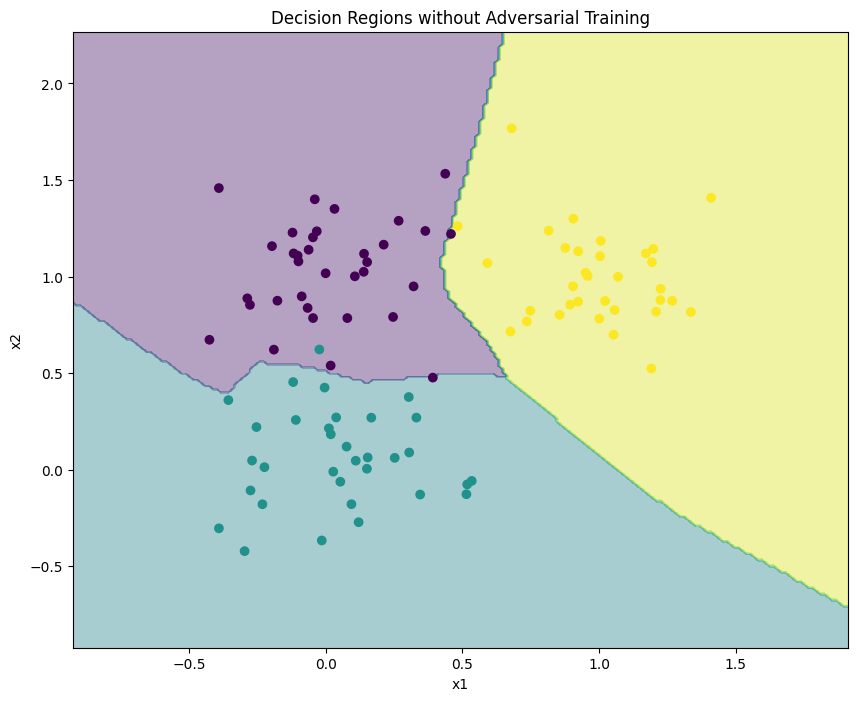

In [3]:
epochs = 1000
lr = 1e-3

net2 = Net()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net2.parameters(), lr=lr)

trainer = BasePyTorchTrainer(optimizer=optimizer, loss=criterion, epochs=epochs)
secmlt_model = BasePytorchClassifier(net2, trainer=trainer)
secmlt_model.train(tr_dataloader)

plot_decision_regions(secmlt_model.model, X_test, y_test, title="Decision Regions without Adversarial Training")

Given this network, we need to tweak the training loop that we saw at the beginning of the course.
Since we have a deep neural network, we **can not** compute adversarial training in closed form.

Hence, the only way is *approximating* the technique by iteratively create adversarial examples while optimizing.
This can be done in multiple ways:

* at each iteration, we create adversarial examples and include them in training (very time consuming)
* train the model for some epochs, compute adversarial attacks, include them in the training, repeat
* fine-tune the trained model with one attack with larger epsilon (less granular, but fast)

Here we are going to use a very easy approach, through Fast Gradient Sign Method (FGSM), which is a single-step attack with a large L-infinity norm.

In [4]:
model = Net()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

epsilon = 0.3

for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in tr_dataloader:
        # Compute adversarial samples with 1-iteration attack
        model.eval()
        x = inputs.clone().detach().requires_grad_(True)
        outputs = model(x)
        loss = criterion(outputs, labels)
        loss.backward()
        gradient = x.grad.data
        inputs_adv = x.data + epsilon * torch.sign(gradient)

        # Fine tuning
        # Compute loss and backpropagate as usual
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs_adv)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(tr_dataloader.dataset)
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

at_model = BasePytorchClassifier(model)

Epoch 100, Loss: 0.6547
Epoch 200, Loss: 0.6502
Epoch 300, Loss: 0.6425
Epoch 400, Loss: 0.6336
Epoch 500, Loss: 0.6302
Epoch 600, Loss: 0.6117
Epoch 700, Loss: 0.5848
Epoch 800, Loss: 0.5561
Epoch 900, Loss: 0.5058
Epoch 1000, Loss: 0.4221


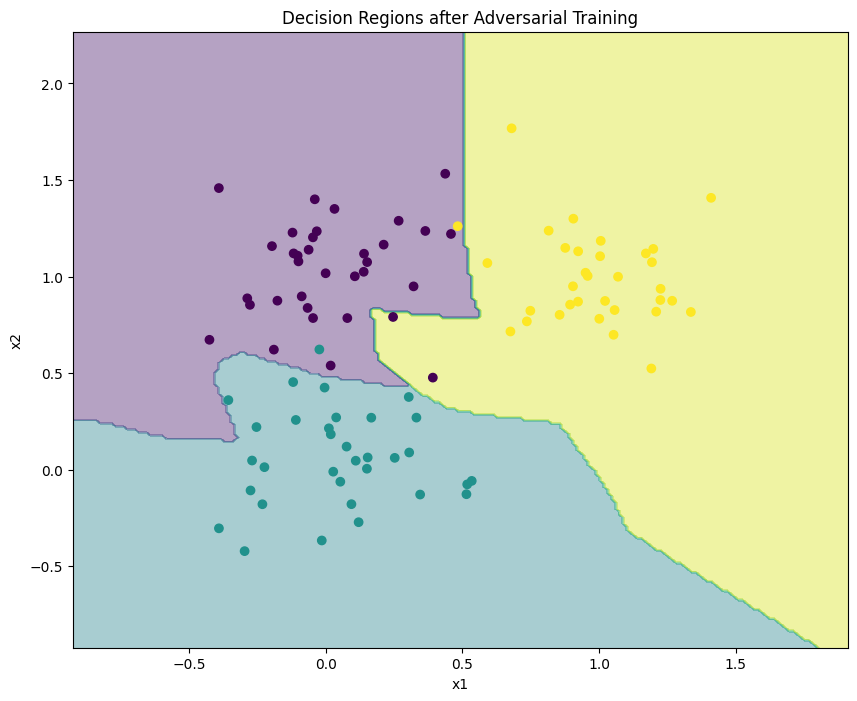

In [5]:
plot_decision_regions(model, X_test, y_test, title="Decision Regions after Adversarial Training")

# Exercise 1
* Perform a security evaluation of both model under the same attack condition (for simplicity, use a PGD attack with varying epsilon)
* Plot the security evaluation curves in the same plot, and try to understand what the comparison is telling regarding the robustness of these models.

In [6]:
from secmlt.adv.evasion.pgd import PGD
from secmlt.adv.backends import Backends
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels

def security_evaluation_pgd_linf(model, testloader, epsilons, iterations=100, stepsize=0.01):
    sec_eval_data = []
    for e in epsilons:
        attack = PGD(
            perturbation_model=LpPerturbationModels.LINF,
            num_steps=iterations,
            step_size=stepsize,
            y_target=None,
            epsilon=e,
            lb=-2,ub=2,
            backend = Backends.NATIVE)
        adv_dataloader = attack(model, testloader)
        robust_accuracy = Accuracy()(model, adv_dataloader)
        sec_eval_data.append(robust_accuracy)
    return sec_eval_data

In [7]:
epsilons = torch.linspace(0, 1.5, steps=10)
iterations = 500
security_eval_no_at = security_evaluation_pgd_linf(secmlt_model, ts_dataloader, epsilons=epsilons,iterations=iterations, stepsize=0.1)
security_eval_at = security_evaluation_pgd_linf(at_model, ts_dataloader, epsilons=epsilons,iterations=iterations, stepsize=0.1)

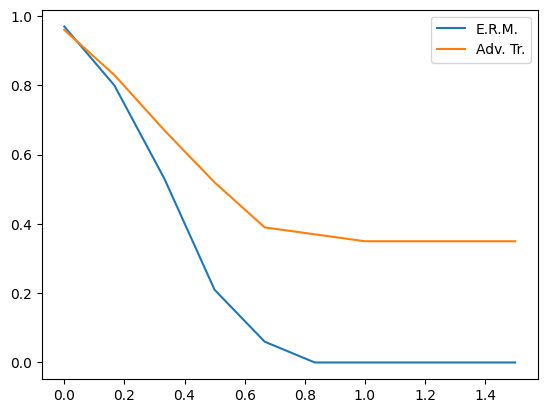

In [8]:
import matplotlib.pyplot as plt

plt.plot(epsilons.numpy(), security_eval_no_at, label='E.R.M.')
plt.plot(epsilons.numpy(), security_eval_at, label='Adv. Tr.')
plt.legend()
plt.show()

### Trying with different norms
#### L1

In [9]:
def security_evaluation_pgd_l1(model, testloader, epsilons, iterations=100, stepsize=0.01):
    sec_eval_data = []
    for e in epsilons:
        attack = PGD(
            perturbation_model=LpPerturbationModels.L1,
            num_steps=iterations,
            step_size=stepsize,
            y_target=None,
            epsilon=e,
            lb=-2,ub=2,
            backend = Backends.NATIVE)
        adv_dataloader = attack(model, testloader)
        robust_accuracy = Accuracy()(model, adv_dataloader)
        sec_eval_data.append(robust_accuracy)
    return sec_eval_data

In [10]:
epsilons = torch.linspace(0, 1.5, steps=10)
iterations = 500
security_eval_no_at = security_evaluation_pgd_l1(secmlt_model, ts_dataloader, epsilons=epsilons,iterations=iterations, stepsize=0.1)
security_eval_at = security_evaluation_pgd_l1(at_model, ts_dataloader, epsilons=epsilons,iterations=iterations, stepsize=0.1)

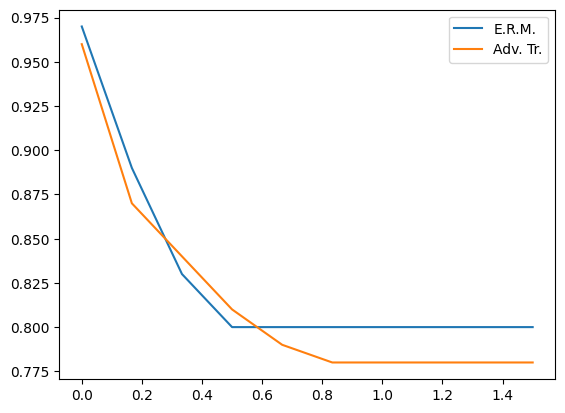

In [11]:
plt.plot(epsilons.numpy(), security_eval_no_at, label='E.R.M.')
plt.plot(epsilons.numpy(), security_eval_at, label='Adv. Tr.')
plt.legend()
plt.show()

#### L2

In [12]:
def security_evaluation_pgd_l2(model, testloader, epsilons, iterations=100, stepsize=0.01):
    sec_eval_data = []
    for e in epsilons:
        attack = PGD(
            perturbation_model=LpPerturbationModels.L2,
            num_steps=iterations,
            step_size=stepsize,
            y_target=None,
            epsilon=e,
            lb=-2,ub=2,
            backend = Backends.NATIVE)
        adv_dataloader = attack(model, testloader)
        robust_accuracy = Accuracy()(model, adv_dataloader)
        sec_eval_data.append(robust_accuracy)
    return sec_eval_data

In [13]:
epsilons = torch.linspace(0, 1.5, steps=10)
iterations = 500
security_eval_no_at = security_evaluation_pgd_l2(secmlt_model, ts_dataloader, epsilons=epsilons,iterations=iterations, stepsize=0.1)
security_eval_at = security_evaluation_pgd_l2(at_model, ts_dataloader, epsilons=epsilons,iterations=iterations, stepsize=0.1)

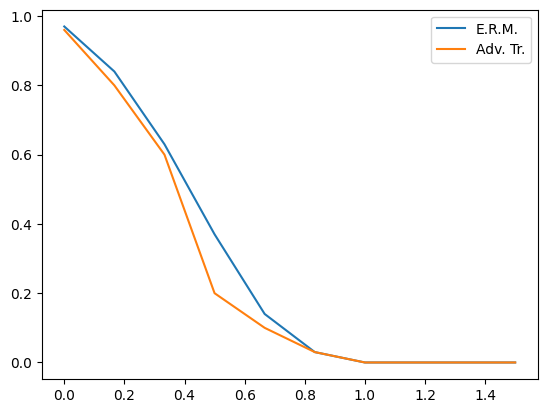

In [14]:
plt.plot(epsilons.numpy(), security_eval_no_at, label='E.R.M.')
plt.plot(epsilons.numpy(), security_eval_at, label='Adv. Tr.')
plt.legend()
plt.show()

### 1. Norma L_\infty (L-Infinito): Perché l'Adv Training vince?**Il motivo:** Hai addestrato il modello esattamente per questo scenario.

* **L'addestramento:** FGSM è intrinsecamente un attacco basato sulla norma L_\infty. La formula x + \epsilon \cdot \text{sign}(\nabla) sposta ogni pixel del valore massimo consentito (\epsilon). Geometricamente, questo crea un "ipercubo" attorno al punto dati originale.
* **Il test:** Quando valuti con PGD-L_\infty, stai testando il modello all'interno dello stesso tipo di geometria (l'ipercubo) su cui lo hai addestrato.
* **Risultato:** Il modello ha imparato a spingere il confine decisionale fuori da questo ipercubo. È come se si fosse "corazzato" contro graffi superficiali su tutti i pixel contemporaneamente.

### 2. Norma L_2 (Euclidea): Perché entrambi "fanno schifo"?**Il motivo:** Geometria incompatibile (Cubo vs Sfera) e natura del gradiente.

* **Geometria:** La norma L_2 vincola la perturbazione all'interno di una "ipersfera". La norma L_\infty (usata in FGSM) vincola dentro un "ipercubo".
* Gli angoli dell'ipercubo (dove FGSM spinge gli esempi) sono molto distanti in termini di distanza euclidea (L_2).
* Tuttavia, esistono punti molto vicini al centro della sfera (L_2 piccola) che non sono coperti dall'addestramento FGSM.


* **Il problema del Segno:** FGSM usa `sign(gradient)`. Questo ignora completamente la *grandezza* del gradiente nelle varie direzioni, trattando tutte le dimensioni come ugualmente importanti. Un attacco PGD-L_2, invece, segue la direzione precisa del gradiente (senza il `sign`), accumulando le perturbazioni dove fanno più male in senso euclideo.
* **Conclusione:** Il tuo modello addestrato con FGSM si è difeso contro attacchi che stanno agli "angoli", ma ha lasciato sguarnite le zone intermedie che PGD-L_2 sfrutta facilmente.

### 3. Norma L_1 (Manhattan): Perché il modello *senza* training è meglio?**Il motivo:** Sparsità e Trade-off.

* **Natura di L_1:** Gli attacchi in norma L_1 cercano di modificare pochissimi pixel ma con valori molto alti (attacchi sparsi).
* **Robustezza Naturale:** I modelli standard (senza adv training) sono spesso sorprendentemente robusti in modo naturale contro la norma L_1 su dataset semplici (come MNIST), perché cambiare pochi pixel raramente altera le feature semantiche profonde che la rete ha imparato.
* **Il danno dell'Adv Training:** L'Adversarial Training non è "gratis". C'è sempre un trade-off. Quando forzi la rete a diventare robusta in L_\infty, stai costringendo il confine decisionale a diventare molto piatto e liscio in tutte le direzioni (per coprire il cubo).
* Questa forzatura spesso riduce la "clean accuracy" (accuratezza sui dati puliti) e può distorcere le feature in modo tale da rendere il modello *più vulnerabile* a perturbazioni di tipo diverso, come quelle sparse (L_1), rispetto a un modello che ha imparato le feature in modo naturale.
* In breve: nel tentativo di difendersi da attacchi su *tutti* i pixel (L_\infty), il modello ha perso la capacità di gestire picchi di rumore su *pochi* pixel (L_1).

# Exercise 2
- Try to use different Net with different number of parameters
Reducing the number of parameters, you basically reduce the intelligence of your model. The model will be dumb.

### Half the params

In [15]:
class Net_dumb(torch.nn.Module):
    def __init__(self):
        super(Net_dumb, self).__init__()
        self.fc1 = torch.nn.Linear(2, 16)
        self.fc2 = torch.nn.Linear(16, 8)
        self.fc3 = torch.nn.Linear(8, 3)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

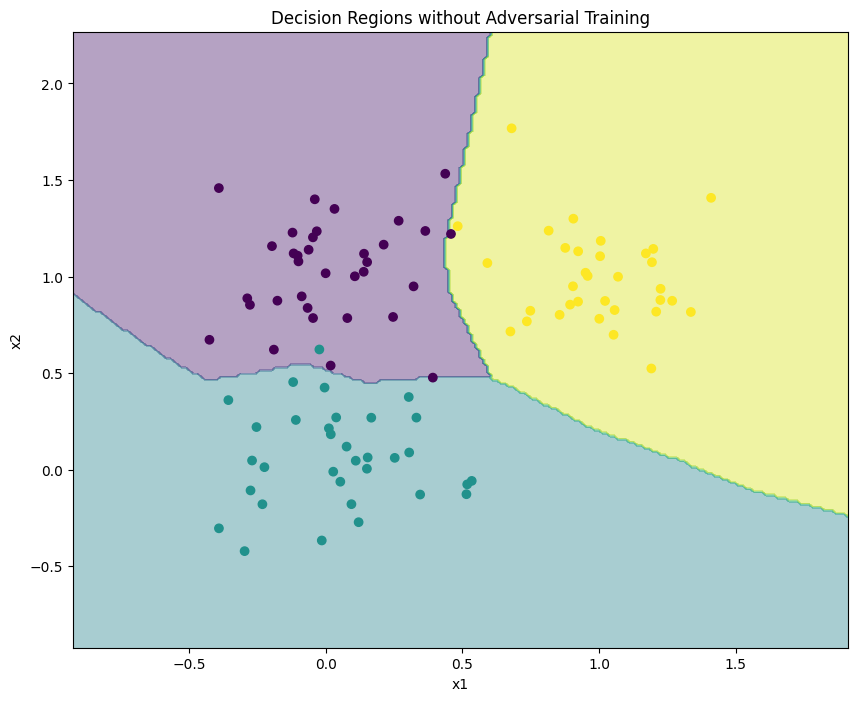

In [16]:
epochs = 1000
lr = 1e-3

net = Net_dumb()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

trainer = BasePyTorchTrainer(optimizer=optimizer, loss=criterion, epochs=epochs)
secmlt_model = BasePytorchClassifier(net, trainer=trainer)
secmlt_model.train(tr_dataloader)

plot_decision_regions(secmlt_model.model, X_test, y_test, title="Decision Regions without Adversarial Training")

In [17]:
model = Net_dumb()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

epsilon = 0.3

for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in tr_dataloader:
        # Compute adversarial samples with 1-iteration attack
        model.eval()
        x = inputs.clone().detach().requires_grad_(True)
        outputs = model(x)
        loss = criterion(outputs, labels)
        loss.backward()
        gradient = x.grad.data
        inputs_adv = x.data + epsilon * torch.sign(gradient)

        # Fine tuning
        # Compute loss and backpropagate as usual
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs_adv)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(tr_dataloader.dataset)
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

at_model = BasePytorchClassifier(model)

Epoch 100, Loss: 0.6642
Epoch 200, Loss: 0.6631
Epoch 300, Loss: 0.6624
Epoch 400, Loss: 0.6567
Epoch 500, Loss: 0.6470
Epoch 600, Loss: 0.5962
Epoch 700, Loss: 0.5476
Epoch 800, Loss: 0.4931
Epoch 900, Loss: 0.4429
Epoch 1000, Loss: 0.4112


In [18]:
epsilons = torch.linspace(0, 1.5, steps=10)
iterations = 500
security_eval_no_at = security_evaluation_pgd_linf(secmlt_model, ts_dataloader, epsilons=epsilons,iterations=iterations, stepsize=0.1)
security_eval_at = security_evaluation_pgd_linf(at_model, ts_dataloader, epsilons=epsilons,iterations=iterations, stepsize=0.1)

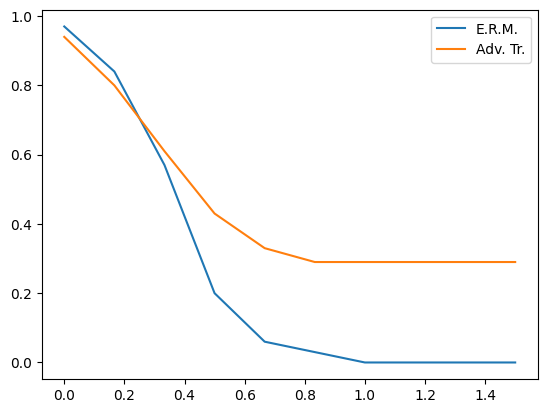

In [19]:
plt.plot(epsilons.numpy(), security_eval_no_at, label='E.R.M.')
plt.plot(epsilons.numpy(), security_eval_at, label='Adv. Tr.')
plt.legend()
plt.show()

### Half half the params

In [20]:
class Net_dumb_dumb(torch.nn.Module):
    def __init__(self):
        super(Net_dumb_dumb, self).__init__()
        self.fc1 = torch.nn.Linear(2, 8)
        self.fc2 = torch.nn.Linear(8, 4)
        self.fc3 = torch.nn.Linear(4, 3)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

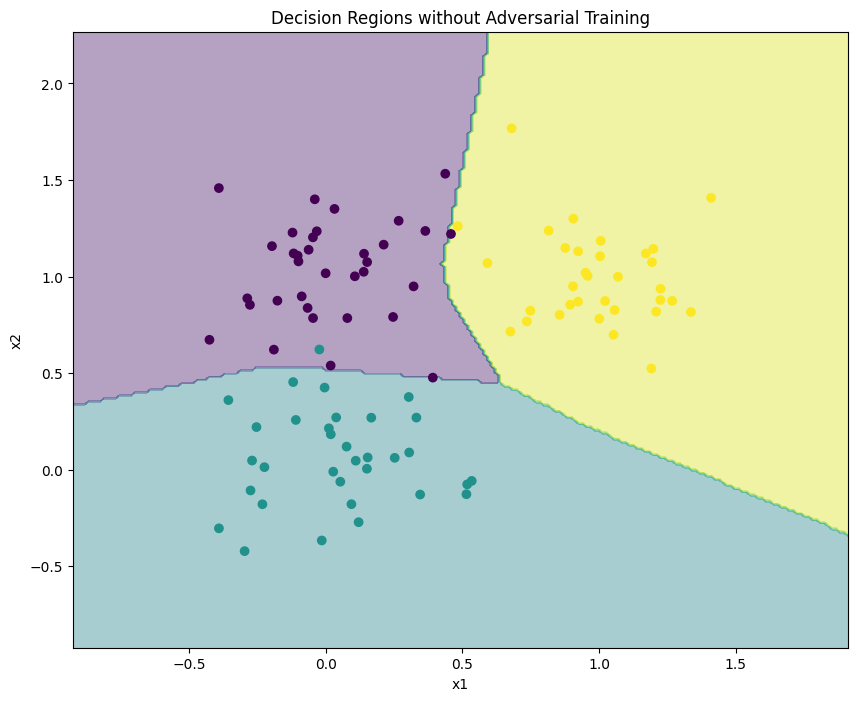

In [21]:
epochs = 1000
lr = 1e-3

net = Net_dumb_dumb()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

trainer = BasePyTorchTrainer(optimizer=optimizer, loss=criterion, epochs=epochs)
secmlt_model = BasePytorchClassifier(net, trainer=trainer)
secmlt_model.train(tr_dataloader)

plot_decision_regions(secmlt_model.model, X_test, y_test, title="Decision Regions without Adversarial Training")

In [22]:
model = Net_dumb_dumb()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

epsilon = 0.3

for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in tr_dataloader:
        # Compute adversarial samples with 1-iteration attack
        model.eval()
        x = inputs.clone().detach().requires_grad_(True)
        outputs = model(x)
        loss = criterion(outputs, labels)
        loss.backward()
        gradient = x.grad.data
        inputs_adv = x.data + epsilon * torch.sign(gradient)

        # Fine tuning
        # Compute loss and backpropagate as usual
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs_adv)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(tr_dataloader.dataset)
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

at_model = BasePytorchClassifier(model)

Epoch 100, Loss: 0.6887
Epoch 200, Loss: 0.6739
Epoch 300, Loss: 0.6713
Epoch 400, Loss: 0.6696
Epoch 500, Loss: 0.6683
Epoch 600, Loss: 0.6678
Epoch 700, Loss: 0.6686
Epoch 800, Loss: 0.6697
Epoch 900, Loss: 0.6706
Epoch 1000, Loss: 0.6704


In [23]:
epsilons = torch.linspace(0, 1.5, steps=10)
iterations = 500
security_eval_no_at = security_evaluation_pgd_linf(secmlt_model, ts_dataloader, epsilons=epsilons,iterations=iterations, stepsize=0.1)
security_eval_at = security_evaluation_pgd_linf(at_model, ts_dataloader, epsilons=epsilons,iterations=iterations, stepsize=0.1)

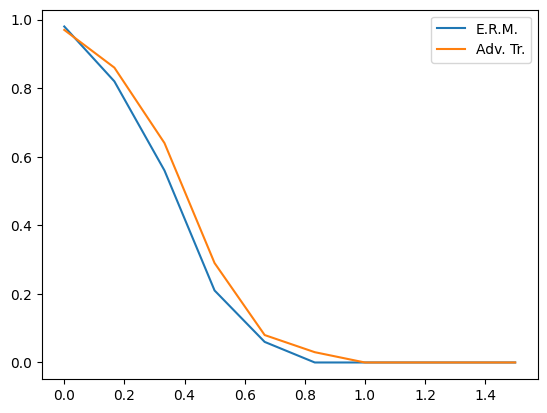

In [24]:
plt.plot(epsilons.numpy(), security_eval_no_at, label='E.R.M.')
plt.plot(epsilons.numpy(), security_eval_at, label='Adv. Tr.')
plt.legend()
plt.show()

# Exercise 3

* Try to change the attack used in adversarial training, for instance using PGD or by increasing the epsilon. What happens if epsilon is too large?
* What happens if the model does not have too many parameters? Can you successfully train it with adversarial training?

### 1. Trying with PGD attack

In [25]:
model = Net()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

alpha = 0.01
num_iter = 10
epsilon = 0.3
lb=-2
ub=2

for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in tr_dataloader:
        # Compute adversarial samples with 1-iteration attack
        model.eval()
        delta = torch.zeros_like(inputs, requires_grad=True)
        deltas = torch.zeros((inputs.shape[0], num_iter) + inputs.shape[1:], device=inputs.device)
        for _ in range(num_iter):
            outputs = model(inputs + delta)
            loss = criterion(outputs, labels)
            loss.backward()

            update = alpha * delta.grad.data.sign()
            delta.data = delta.data + update

            delta.data = torch.clamp(delta.data, -epsilon, epsilon)
            delta.data = torch.clamp(delta.data, lb - inputs.data, ub - inputs.data)
            delta.grad.zero_()

        inputs_adv = (inputs + delta).detach()

        # Fine tuning
        # Compute loss and backpropagate as usual
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs_adv)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(tr_dataloader.dataset)
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

at_pgd_model = BasePytorchClassifier(model)

Epoch 100, Loss: 0.2039
Epoch 200, Loss: 0.2027
Epoch 300, Loss: 0.2002
Epoch 400, Loss: 0.1989
Epoch 500, Loss: 0.1976
Epoch 600, Loss: 0.1966
Epoch 700, Loss: 0.1953
Epoch 800, Loss: 0.1945
Epoch 900, Loss: 0.1943
Epoch 1000, Loss: 0.1936


In [26]:
epsilons = torch.linspace(0, 1.5, steps=10)
iterations = 500
security_eval_no_at = security_evaluation_pgd_linf(secmlt_model, ts_dataloader, epsilons=epsilons,iterations=iterations, stepsize=0.1)
security_eval_at = security_evaluation_pgd_linf(at_pgd_model, ts_dataloader, epsilons=epsilons,iterations=iterations, stepsize=0.1)

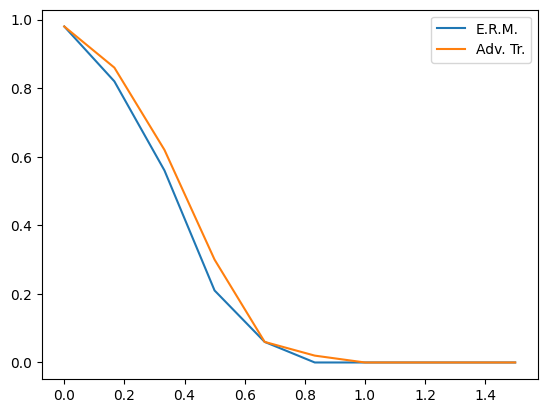

In [27]:
plt.plot(epsilons.numpy(), security_eval_no_at, label='E.R.M.')
plt.plot(epsilons.numpy(), security_eval_at, label='Adv. Tr.')
plt.legend()
plt.show()